In [1]:
from gerrychain import Graph
from geopy.distance import geodesic
import math
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd

In [2]:
# Read Alabama county graph from the json file "AL_county.json"
filepath = "C:\\Users\\19186\\Downloads\\Alabama_Redistricting\\Data\\"
filename = 'AL_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, population, and lat-long coordinates
for node in G.nodes:
    name = G.nodes[node]["NAME20"]
    population = G.nodes[node]['P0010001'] 
    G.nodes[node]['TOTPOP'] = population
    
    # query lat and long coordinates 
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20'] #longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20'] #Latitude of county's center

In [5]:
# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = (G.nodes[i]['C_Y'], G.nodes[i]['C_X'])
        loc_j = (G.nodes[j]['C_Y'], G.nodes[j]['C_X'])
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [6]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

# number of districts
k = 7          

total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

#get the lower and upper bounds of the population per district
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 714166 and U = 721342 and k = 7


In [7]:
# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY) 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


In [8]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective(gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]["TOTPOP"] * x[i,j] for i in G.nodes for j in G.nodes))

In [9]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k)

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum(G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes)
m.addConstrs( gp.quicksum(G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes)

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes)

m.update()

In [10]:
# Add contiguity constraints
DG = nx.DiGraph(G)

# Add variable f[j,u,v] which equals the amount of flow (originally from j) that is sent across arc (u,v)
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes()-1

# Add constraint saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes )

# Add constraints saying that node i can receive flow of type j only if i is assigned to j
m.addConstrs( gp.quicksum( f[j,u,i] for u in DG.neighbors(i)) <= M * x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

# If i is assigned to j, then i should consume one unit of j flow. 
# Otherwise, i should consume no units of j flow.
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in DG.neighbors(i)) == x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()

In [11]:
# solve, and setting 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0
m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13602 rows, 27403 columns and 99280 nonzeros
Model fingerprint: 0xa36d7458
Variable types: 22914 continuous, 4489 integer (4489 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [3e+06, 4e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 575 rows and 1552 columns
Presolve time: 1.27s
Presolved: 13027 rows, 25851 columns, 95568 nonzeros
Variable types: 21445 continuous, 4406 integer (4406 binary)

Root relaxation: objective 5.572088e+09, 1800 iterations, 0.92 seconds (0.25 work units)

    Nodes    |    Current Node    |     Objective B

In [16]:
# print the objective value
print(m.objVal)
print("")

# retrieve the districts and their populations
# but first get the district "centers"

centers = [j for j in G.nodes if x[j,j].x > 0.5]

districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

6593085384.640669

District 0 has population 714963 and contains counties ['Cleburne', 'Tallapoosa', 'Crenshaw', 'Calhoun', 'Elmore', 'Randolph', 'Clay', 'Cherokee', 'Lee', 'Chambers', 'Lowndes', 'Talladega', 'Autauga', 'Macon']

District 1 has population 720310 and contains counties ['Jefferson', 'Bibb', 'Hale', 'Perry']

District 2 has population 717488 and contains counties ['Clarke', 'Washington', 'Mobile', 'Monroe', 'Baldwin', 'Choctaw']

District 3 has population 718247 and contains counties ['Shelby', 'Dallas', 'Pickens', 'Walker', 'Chilton', 'Marengo', 'Greene', 'Fayette', 'Tuscaloosa', 'Wilcox', 'Coosa', 'Sumter', 'Winston']

District 4 has population 719832 and contains counties ['Lawrence', 'Morgan', 'Etowah', 'DeKalb', 'Marshall', 'Blount', 'Jackson', 'St. Clair', 'Cullman']

District 5 has population 717940 and contains counties ['Lauderdale', 'Madison', 'Lamar', 'Franklin', 'Colbert', 'Limestone', 'Marion']

District 6 has population 715499 and contains counties ['Barbour

In [13]:
# Let's draw it on a map
# Read Alabama county shapefile from "OK_county.shp"
filepath = "C:\\Users\\19186\\Downloads\\Alabama_Redistricting\\Data\\"
filename = 'AL_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

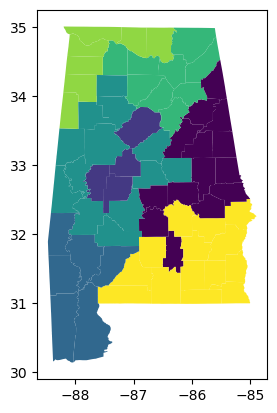

In [14]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = {G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # postion u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]

#now add the assignents to a column of our dataframe then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()